# Exercise 2
# Part 2.1 Detectors

Μια πρώτη απλή υλοποίηση του αλγορίθμου HarrisDetection3D

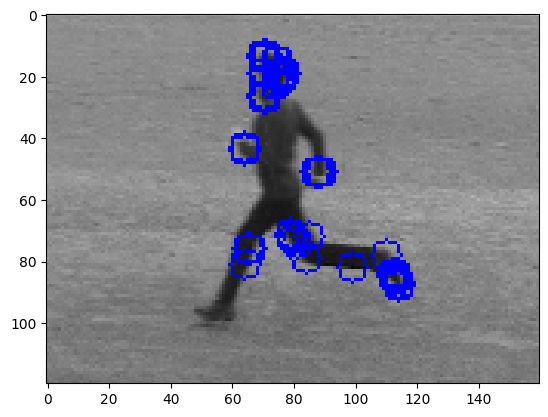

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load all three frames
frame1 = cv2.imread('frame_217.png', cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread('frame_218.png', cv2.IMREAD_GRAYSCALE)
frame3 = cv2.imread('frame_219.png', cv2.IMREAD_GRAYSCALE)

# Compute second spatial derivatives using Sobel operator applied twice
grad_xx = cv2.Sobel(cv2.Sobel(frame2, cv2.CV_64F, 1, 0, ksize=3), cv2.CV_64F, 1, 0, ksize=3)
grad_yy = cv2.Sobel(cv2.Sobel(frame2, cv2.CV_64F, 0, 1, ksize=3), cv2.CV_64F, 0, 1, ksize=3)

# Compute second-order temporal derivative using central difference
grad_tt = np.float64(frame3) - 2 * np.float64(frame2) + np.float64(frame1)

# Gaussian blur on the derivatives
sigma = 0.5
grad_xx = cv2.GaussianBlur(grad_xx, (5, 5), sigmaX=sigma)
grad_yy = cv2.GaussianBlur(grad_yy, (5, 5), sigmaX=sigma)
grad_tt = cv2.GaussianBlur(grad_tt, (5, 5), sigmaX=sigma)

# Harris' response calculation using adjusted Laplacian components
k = 0.001  # Sensitivity factor
det_M = grad_xx * grad_yy * grad_tt
trace_M = grad_xx + grad_yy + grad_tt

R_true_laplacian = det_M - k * (trace_M ** 3)
threshold = 0.3
R_true_laplacian = (R_true_laplacian > threshold * R_true_laplacian.max()) * R_true_laplacian

# Display corners
corners_true_laplacian = np.where(R_true_laplacian > 0)
output_image_true_laplacian = cv2.cvtColor(frame2, cv2.COLOR_GRAY2BGR)
for y, x in zip(*corners_true_laplacian):
    cv2.circle(output_image_true_laplacian, (x, y), 5, (0, 0, 255), 1)  # mark with red circles

# Save the image with corners marked using true Laplacian components
cv2.imwrite('corners_detected_true_laplacian.png', output_image_true_laplacian)
plt.imshow(output_image_true_laplacian)

Καλά δομημένη κλάση που υπολογίζει τα σημεία ενδιαφέροντος με τον αλγόριθμο Harris

In [1]:
import cv2
import numpy as np


class HarrisDetector3D:
    def __init__(self, k=0.001, threshold=0.3, sigma=2):
        self.k = k  # Sensitivity factor
        self.threshold = threshold  # Threshold for corner response
        self.sigma = sigma  # Gaussian sigma

    def apply_sobel(self, frame, order, axis):
        if axis == 'x':
            return cv2.Sobel(frame, cv2.CV_64F, 1 if order == 1 else 2, 0, ksize=3)
        elif axis == 'y':
            return cv2.Sobel(frame, cv2.CV_64F, 0, 1 if order == 1 else 2, ksize=3)

    def process_frame(self, frame1, frame2, frame3):
        # Compute second spatial derivatives using Sobel operator applied twice
        grad_xx = self.apply_sobel(frame2, 2, 'x')
        grad_yy = self.apply_sobel(frame2, 2, 'y')

        # Compute second-order temporal derivative using central difference
        grad_tt = np.float64(frame3) - 2 * np.float64(frame2) + np.float64(frame1)

        # Gaussian blur on the derivatives
        grad_xx = cv2.GaussianBlur(grad_xx, (5, 5), sigmaX=self.sigma)
        grad_yy = cv2.GaussianBlur(grad_yy, (5, 5), sigmaX=self.sigma)
        grad_tt = cv2.GaussianBlur(grad_tt, (5, 5), sigmaX=self.sigma)

        # Harris' response calculation using adjusted Laplacian components
        det_M = grad_xx * grad_yy * grad_tt
        trace_M = grad_xx + grad_yy + grad_tt

        R_true_laplacian = det_M - self.k * (trace_M ** 3)
        return (R_true_laplacian > self.threshold * R_true_laplacian.max()).astype(np.uint8)

    def mark_corners(self, frame, response):
        corners = np.where(response > 0)
        output_image = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        for y, x in zip(*corners):
            cv2.circle(output_image, (x, y), 5, (0, 0, 255), 1)  # mark with red circles
        return output_image

    def process_video(self, input_path, output_path):
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return

        ret, frame1 = cap.read()
        ret, frame2 = cap.read()

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

        while True:
            ret, frame3 = cap.read()
            if not ret:
                break

            gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
            gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
            gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

            # Process frames
            response = self.process_frame(gray1, gray2, gray3)
            output_image = self.mark_corners(gray2, response)
            out.write(output_image)

            # Move to the next frame set
            frame1, frame2 = frame2, frame3

        cap.release()
        out.release()
        print("Video processing complete. Output saved to:", output_path)


# Usage example (please update the path accordingly):
detector = HarrisDetector3D()
video_path = 'cv24_lab2_part2/walking/person04_walking_d1_uncomp.avi'
detector.process_video(video_path, f'HarrisBoxingPOI.avi')


Video processing complete. Output saved to: HarrisBoxingPOI.avi


Καλά δομημένη κλάση που υπολογίζει τα σημεία ενδιαφέροντος με τον αλγόριθμο Gabor


In [2]:
import cv2
import numpy as np
import math

class GaborFeatureExtractor:
    def __init__(self, sigma=1, theta=np.pi / 4, lam=1, psi=0, gamma=1):
        self.sigma = sigma  # Standard deviation of the Gaussian envelope
        self.theta = theta  # Orientation of the normal to the parallel stripes
        self.lam = lam  # Wavelength of the sinusoidal factor
        self.psi = psi  # Phase offset
        self.gamma = gamma  # Spatial aspect ratio

    def gabor_kernel(self, ksize=20):
        # Calculate the Gabor kernel using the parameters provided
        sigma_x = self.sigma
        sigma_y = float(sigma_x) / self.gamma

        # Bounding box
        nstds = 3  # Number of standard deviation sigma
        xmax = max(abs(nstds * sigma_x * np.cos(self.theta)), abs(nstds * sigma_y * np.sin(self.theta)))
        xmax = np.ceil(max(1, xmax))
        ymax = max(abs(nstds * sigma_x * np.sin(self.theta)), abs(nstds * sigma_y * np.cos(self.theta)))
        ymax = np.ceil(max(1, ymax))
        xmin = -xmax
        ymin = -ymax

        (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

        # Rotation
        x_theta = x * np.cos(self.theta) + y * np.sin(self.theta)
        y_theta = -x * np.sin(self.theta) + y * np.cos(self.theta)

        gb = np.exp(-0.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * \
             np.cos(2 * np.pi / self.lam * x_theta + self.psi)
        return gb

    def apply_gabor(self, frame):
        kernel = self.gabor_kernel()
        return cv2.filter2D(frame, -1, kernel)

    def process_frame(self, frame1, frame2, frame3):
        gabor1 = self.apply_gabor(frame1)
        gabor2 = self.apply_gabor(frame2)
        gabor3 = self.apply_gabor(frame3)
        
        # Combine the responses to create a 3D response (stack the responses)
        response = np.sqrt(gabor1**2 + gabor2**2 + gabor3**2)
        
        return response

    def process_video(self, input_path, output_path):
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            print("Error: Could not open video.")
            return

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gabor_filtered = self.apply_gabor(gray)
            output_image = cv2.cvtColor(gabor_filtered, cv2.COLOR_GRAY2BGR)
            out.write(output_image)

        cap.release()
        out.release()
        print("Video processing complete. Output saved to:", output_path)

# Usage example (please update the path accordingly):
video_path = 'cv24_lab2_part2/walking/person04_walking_d1_uncomp.avi'
gabor_extractor = GaborFeatureExtractor(sigma=1, theta=np.pi / 4, lam=4 / 1.5, psi=0.6 * np.pi, gamma=.8)
gabor_extractor.process_video(video_path, f'GaborWalkingPOI2.avi')

Video processing complete. Output saved to: GaborWalkingPOI2.avi


# Part 2.2 Descriptors

In [8]:
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import pickle
from cv24_lab2_part2.utils import orientation_histogram


def save_descriptors(descriptors, filename='harris_descriptors.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(descriptors, f)


def load_descriptors(filename='harris_descriptors.pkl'):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return []

def load_videos_and_extract_features(base_path):
    labels = ['boxing', 'running', 'walking']
    all_descriptors = load_descriptors()  # Load existing descriptors

    for label in labels:
        directory = os.path.join(base_path, label)
        videos = os.listdir(directory)
        for filename in tqdm(videos, desc=f'Processing {label} videos'):
            video_path = os.path.join(directory, filename)
            if not video_path.endswith('.avi'):
                continue
            # Skip processing if this video's descriptors are already saved
            if any(d['video_name'] == filename for d in all_descriptors):
                continue
            descriptors = extract_descriptors_from_video(video_path, detector)  # detector is global var
            for desc in descriptors:
                all_descriptors.append({
                    'video_name': filename,
                    'label': label,
                    'hog_descriptors': desc[0],
                    'hof_descriptors': desc[1]
                })
            # Save after processing each video
            save_descriptors(all_descriptors)

    return all_descriptors


def extract_descriptors_from_video(video_path, detector):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []  # If the video can't be opened, return an empty list

    tv_l1 = cv2.optflow.DualTVL1OpticalFlow_create()
    nbins = 20
    grid_size = 4

    ret, frame1 = cap.read()
    ret, frame2 = cap.read()
    descriptors = []

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=frame_count, desc='Extracting descriptors') as pbar:
        while True:
            ret, frame3 = cap.read()
            if not ret:
                break

            gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
            gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
            gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)

            # Process frames to get Harris responses
            response = detector.process_frame(gray1, gray2, gray3)
            points_of_interest = np.array(np.where(response > 0)).T

            for y, x in points_of_interest:
                if x - grid_size < 0 or y - grid_size < 0 or x + grid_size >= gray2.shape[1] or y + grid_size >= \
                        gray2.shape[0]:
                    continue  # Skip points too close to the edge

                local_patch_prev = gray2[y - grid_size:y + grid_size, x - grid_size:x + grid_size]
                local_patch_current = gray3[y - grid_size:y + grid_size, x - grid_size:x + grid_size]

                Gx = cv2.Sobel(local_patch_prev, cv2.CV_64F, 1, 0, ksize=5)
                Gy = cv2.Sobel(local_patch_prev, cv2.CV_64F, 0, 1, ksize=5)
                flow = tv_l1.calc(local_patch_prev, local_patch_current, None)

                hog_desc = orientation_histogram(Gx, Gy, nbins, np.array([2 * grid_size, 2 * grid_size]))
                hof_desc = orientation_histogram(flow[..., 0], flow[..., 1], nbins,
                                                 np.array([2 * grid_size, 2 * grid_size]))

                descriptors.append((hog_desc.ravel(), hof_desc.ravel()))

            pbar.update(1)
            frame1, frame2 = frame2, frame3  # Move to the next frame set

    cap.release()
    return descriptors


In [9]:
# Example usage
base_path = 'cv24_lab2_part2'
all_descriptors = load_videos_and_extract_features(base_path)

Processing boxing videos:   0%|          | 0/16 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/390 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/490 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/512 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/328 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/444 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/412 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/415 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/545 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/701 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/294 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/365 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/417 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/448 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/382 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/396 [00:00<?, ?it/s]

Processing running videos:   0%|          | 0/16 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/335 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/1492 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/375 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/230 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/285 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/385 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/266 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/345 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/274 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/325 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/480 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/330 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/330 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/332 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/392 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/294 [00:00<?, ?it/s]

Processing walking videos:   0%|          | 0/16 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/470 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/675 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/408 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/550 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/750 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/640 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/850 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/670 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/555 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/741 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/750 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/725 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/492 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/525 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/495 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/592 [00:00<?, ?it/s]

# Part 2.3 Classification

In [16]:
from pprint import pprint

pprint(all_descriptors[0])
pprint(all_descriptors[400])
pprint(all_descriptors[40_000])
pprint(all_descriptors[400_000])

{'hof_descriptors': array([0., 0., 0., ..., 0., 0., 0.]),
 'hog_descriptors': array([0.03458304, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]),
 'label': 'boxing',
 'video_name': 'person01_boxing_d2_uncomp.avi'}
{'hof_descriptors': array([0.99276653, 0.12006092, 0.        , ..., 0.        , 0.        ,
       0.        ]),
 'hog_descriptors': array([0.03540026, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]),
 'label': 'boxing',
 'video_name': 'person01_boxing_d2_uncomp.avi'}
{'hof_descriptors': array([0., 0., 0., ..., 0., 0., 0.]),
 'hog_descriptors': array([0.03522853, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]),
 'label': 'boxing',
 'video_name': 'person11_boxing_d2_uncomp.avi'}
{'hof_descriptors': array([1., 0., 0., ..., 0., 0., 0.]),
 'hog_descriptors': array([0.13544287, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]),
 'label': 'walking',
 'video_name': 'person18_walking_d4_

In [17]:
from collections import defaultdict
import numpy as np


def aggregate_descriptors(descriptors):
    video_aggregate = defaultdict(lambda: {'hog_descriptors': [], 'hof_descriptors': [], 'label': None})

    for desc in descriptors:
        video_name = desc['video_name']
        video_aggregate[video_name]['hog_descriptors'].append(desc['hog_descriptors'])
        video_aggregate[video_name]['hof_descriptors'].append(desc['hof_descriptors'])

        # Ensure that the label is set (it should be the same for all entries of the same video)
        if video_aggregate[video_name]['label'] is None:
            video_aggregate[video_name]['label'] = desc['label']

    # Now, convert lists of descriptors to a single numpy array for each type
    for video_name, data in video_aggregate.items():
        data['hog_descriptors'] = np.vstack(data['hog_descriptors'])  # Stack descriptors vertically
        data['hof_descriptors'] = np.vstack(data['hof_descriptors'])  # Stack descriptors vertically

    return video_aggregate


video_descriptors = aggregate_descriptors(all_descriptors)

# Printing the aggregated descriptor for one video to check the output
from pprint import pprint

pprint(video_descriptors['person01_boxing_d2_uncomp.avi'])


{'hof_descriptors': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.18712783, 0.12653278,
        0.        ],
       [0.        , 0.        , 0.15709252, ..., 0.        , 0.        ,
        0.        ]]),
 'hog_descriptors': array([[0.03458304, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05513424, 0.        , 0.        , ..., 0.51222902, 0.3098575 ,
        0.        ],
       [0.34088486, 0.        , 0.40368672, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.15648672, 0.        , 0.        , ..., 0.        , 0.        ,
        0.     

In [21]:
video_descriptors.keys()

dict_keys(['person01_boxing_d2_uncomp.avi', 'person02_boxing_d3_uncomp.avi', 'person03_boxing_d4_uncomp.avi', 'person04_boxing_d1_uncomp.avi', 'person05_boxing_d2_uncomp.avi', 'person06_boxing_d1_uncomp.avi', 'person07_boxing_d3_uncomp.avi', 'person09_boxing_d4_uncomp.avi', 'person11_boxing_d2_uncomp.avi', 'person12_boxing_d3_uncomp.avi', 'person15_boxing_d4_uncomp.avi', 'person21_boxing_d1_uncomp.avi', 'person22_boxing_d2_uncomp.avi', 'person23_boxing_d3_uncomp.avi', 'person24_boxing_d4_uncomp.avi', 'person25_boxing_d1_uncomp.avi', 'person01_running_d1_uncomp.avi', 'person02_running_d2_uncomp.avi', 'person03_running_d3_uncomp.avi', 'person04_running_d4_uncomp.avi', 'person05_running_d1_uncomp.avi', 'person06_running_d2_uncomp.avi', 'person06_running_d3_uncomp.avi', 'person07_running_d3_uncomp.avi', 'person08_running_d4_uncomp.avi', 'person09_running_d1_uncomp.avi', 'person10_running_d2_uncomp.avi', 'person20_running_d1_uncomp.avi', 'person21_running_d4_uncomp.avi', 'person23_running_d

In [23]:
def load_training_set(filename):
    with open(filename, 'r') as file:
        training_videos = file.read().splitlines()
    return training_videos


def split_train_test(video_descriptors, training_videos):
    train_descriptors = {}
    test_descriptors = {}

    for video_name, descriptors in video_descriptors.items():
        if video_name in training_videos:
            train_descriptors[video_name] = descriptors
        else:
            test_descriptors[video_name] = descriptors

    return train_descriptors, test_descriptors


# Load the training set video names
training_set_filename = 'cv24_lab2_part2/traininng_set.txt'  # Update the path to where you have saved training_set.txt
training_videos = load_training_set(training_set_filename)

# Split the video descriptors into training and testing sets
train_descriptors, test_descriptors = split_train_test(video_descriptors, training_videos)

# Optional: Print out the count of videos in each set to verify
print("Training set size:", len(train_descriptors))
print("Testing set size:", len(test_descriptors))


Training set size: 36
Testing set size: 12


In [25]:
from cv24_lab2_part2.utils import bag_of_words


def prepare_descriptors(descriptors_dict):
    prepared_descriptors = []
    for video_data in descriptors_dict.values():
        # Assuming each video's descriptors are already aggregated into numpy arrays
        combined_descriptors = np.hstack((video_data['hog_descriptors'], video_data['hof_descriptors']))
        prepared_descriptors.append(combined_descriptors)
    return prepared_descriptors


# Prepare the training and testing descriptor lists
train_descriptors_list = prepare_descriptors(train_descriptors)
test_descriptors_list = prepare_descriptors(test_descriptors)

# Assuming the function 'bagofwords' is available and works as described
# You need to define the number of visual words (numcenters) based on your needs or experiments
num_centers = 100  # Example value for the number of visual words

# Call the bagofwords function with the prepared descriptors
bowtrain, bowtest = bag_of_words(train_descriptors_list, test_descriptors_list, num_centers)

In [26]:
import pickle

# Define the file paths for the serialized data
train_path = 'harris_bowtrain.pkl'
test_path = 'harris_bowtest.pkl'

# Save the bowtrain data
with open(train_path, 'wb') as f:
    pickle.dump(bowtrain, f)

# Save the bowtest data
with open(test_path, 'wb') as f:
    pickle.dump(bowtest, f)

print("BoVW data successfully saved!")

BoVW data successfully saved!


In [27]:
# Load the bowtrain data
with open(train_path, 'rb') as f:
    bowtrain_loaded = pickle.load(f)

# Load the bowtest data
with open(test_path, 'rb') as f:
    bowtest_loaded = pickle.load(f)

print("BoVW data successfully loaded!")


BoVW data successfully loaded!


In [50]:
# Assuming svmtraintest is imported from utils and works as described
from cv24_lab2_part2.utils import svm_train_test


def extract_labels(descriptor_dict):
    labels = [data['label'] for data in descriptor_dict.values()]
    return labels


# Extract labels for training and testing sets
train_labels = extract_labels(train_descriptors)
test_labels = extract_labels(test_descriptors)

# Now call the svmtraintest function with the BoVW histograms and labels
accuracy, predictions = svm_train_test(bowtrain, train_labels, bowtest, test_labels)

# Output the results
print(f'Training Accuracy: {accuracy * 100:.2f}%')
print(f'Predictions: {predictions}')


Training Accuracy: 91.67%
Predictions: ['boxing' 'boxing' 'boxing' 'boxing' 'walking' 'running' 'running'
 'running' 'walking' 'walking' 'walking' 'walking']


# A more compact implementation, here we have
- **DescriptorManager** class for all the functions above related to descriptors generation and training-pre-processing
- **Classifier** class for the svm training
We didn't run the training here because it would take more that 30 hours to train but as the resulting videos show, the GaborFeatureExtractor worked very well, so we expect that if we trained this the results would be great as they did for HarrisDetector3D above

In [3]:
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import pickle
from typing import Union
from collections import defaultdict
from cv24_lab2_part2.utils import orientation_histogram, bag_of_words

class DescriptorManager:
    def __init__(self, filename='gabor_descriptors.pkl'):
        self.filename = filename
        self.descriptors = self.load_descriptors()

    def save_descriptors(self):
        with open(self.filename, 'wb') as f:
            pickle.dump(self.descriptors, f)

    def load_descriptors(self):
        try:
            with open(self.filename, 'rb') as f:
                return pickle.load(f)
        except FileNotFoundError:
            return []

    def load_videos_and_extract_features(self, base_path, detector):
        labels = ['boxing', 'running', 'walking']
        for label in labels:
            directory = os.path.join(base_path, label)
            videos = os.listdir(directory)
            for filename in tqdm(videos, desc=f'Processing {label} videos'):
                video_path = os.path.join(directory, filename)
                if not video_path.endswith('.avi'):
                    continue
                if any(d['video_name'] == filename for d in self.descriptors):
                    continue
                descriptors = self.extract_descriptors_from_video(video_path, detector)
                for desc in descriptors:
                    self.descriptors.append({
                        'video_name': filename,
                        'label': label,
                        'hog_descriptors': desc[0],
                        'hof_descriptors': desc[1]
                    })
                self.save_descriptors()
        return self.descriptors

    def extract_descriptors_from_video(self, video_path, detector: Union[HarrisDetector3D, GaborFeatureExtractor]):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return []
        tv_l1 = cv2.optflow.DualTVL1OpticalFlow_create()
        nbins = 20
        grid_size = 4
        ret, frame1 = cap.read()
        ret, frame2 = cap.read()
        descriptors = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        with tqdm(total=frame_count, desc='Extracting descriptors') as pbar:
            while True:
                ret, frame3 = cap.read()
                if not ret:
                    break
                gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
                gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
                gray3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)
                response = detector.process_frame(gray1, gray2, gray3)
                points_of_interest = np.array(np.where(response > 0)).T
                for y, x in points_of_interest:
                    if x - grid_size < 0 or y - grid_size < 0 or x + grid_size >= gray2.shape[1] or y + grid_size >= gray2.shape[0]:
                        continue
                    local_patch_prev = gray2[y - grid_size:y + grid_size, x - grid_size:x + grid_size]
                    local_patch_current = gray3[y - grid_size:y + grid_size, x - grid_size:x + grid_size]
                    Gx = cv2.Sobel(local_patch_prev, cv2.CV_64F, 1, 0, ksize=5)
                    Gy = cv2.Sobel(local_patch_prev, cv2.CV_64F, 0, 1, ksize=5)
                    flow = tv_l1.calc(local_patch_prev, local_patch_current, None)
                    hog_desc = orientation_histogram(Gx, Gy, nbins, np.array([2 * grid_size, 2 * grid_size]))
                    hof_desc = orientation_histogram(flow[..., 0], flow[..., 1], nbins, np.array([2 * grid_size, 2 * grid_size]))
                    descriptors.append((hog_desc.ravel(), hof_desc.ravel()))
                pbar.update(1)
                frame1, frame2 = frame2, frame3
        cap.release()
        return descriptors

    def aggregate_descriptors(self):
        video_aggregate = defaultdict(lambda: {'hog_descriptors': [], 'hof_descriptors': [], 'label': None})
        for desc in self.descriptors:
            video_name = desc['video_name']
            video_aggregate[video_name]['hog_descriptors'].append(desc['hog_descriptors'])
            video_aggregate[video_name]['hof_descriptors'].append(desc['hof_descriptors'])
            if video_aggregate[video_name]['label'] is None:
                video_aggregate[video_name]['label'] = desc['label']
        for video_name, data in video_aggregate.items():
            data['hog_descriptors'] = np.vstack(data['hog_descriptors'])
            data['hof_descriptors'] = np.vstack(data['hof_descriptors'])
        return video_aggregate

    def prepare_descriptors(self, descriptors_dict):
        prepared_descriptors = []
        for video_data in descriptors_dict.values():
            combined_descriptors = np.hstack((video_data['hog_descriptors'], video_data['hof_descriptors']))
            prepared_descriptors.append(combined_descriptors)
        return prepared_descriptors

    def split_train_test(self, video_descriptors, training_videos):
        train_descriptors = {}
        test_descriptors = {}
        for video_name, descriptors in video_descriptors.items():
            if video_name in training_videos:
                train_descriptors[video_name] = descriptors
            else:
                test_descriptors[video_name] = descriptors
        return train_descriptors, test_descriptors

    def load_training_set(self, filename):
        with open(filename, 'r') as file:
            training_videos = file.read().splitlines()
        return training_videos

In [4]:
from cv24_lab2_part2.utils import svm_train_test
import pickle

class Classifier:
    def __init__(self, num_centers=100):
        self.num_centers = num_centers

    def train_test_split(self, train_descriptors, test_descriptors):
        train_descriptors_list = DescriptorManager().prepare_descriptors(train_descriptors)
        test_descriptors_list = DescriptorManager().prepare_descriptors(test_descriptors)
        bowtrain, bowtest = bag_of_words(train_descriptors_list, test_descriptors_list, self.num_centers)
        return bowtrain, bowtest

    def save_bovw_data(self, bowtrain, bowtest, train_path='harris_bowtrain.pkl', test_path='harris_bowtest.pkl'):
        with open(train_path, 'wb') as f:
            pickle.dump(bowtrain, f)
        with open(test_path, 'wb') as f:
            pickle.dump(bowtest, f)
        print("BoVW data successfully saved!")

    def load_bovw_data(self, train_path='harris_bowtrain.pkl', test_path='harris_bowtest.pkl'):
        with open(train_path, 'rb') as f:
            bowtrain = pickle.load(f)
        with open(test_path, 'rb') as f:
            bowtest = pickle.load(f)
        print("BoVW data successfully loaded!")
        return bowtrain, bowtest

    def extract_labels(self, descriptor_dict):
        labels = [data['label'] for data in descriptor_dict.values()]
        return labels

    def classify(self, bowtrain, train_labels, bowtest, test_labels):
        accuracy, predictions = svm_train_test(bowtrain, train_labels, bowtest, test_labels)
        print(f'Training Accuracy: {accuracy * 100:.2f}%')
        print(f'Predictions: {predictions}')
        return accuracy, predictions


In [5]:
from pprint import pprint

# Αρχικοποίηση των κλάσεων
descriptor_manager = DescriptorManager(filename='gabor_descriptors.pkl')
classifier = Classifier(num_centers=100)

# Φόρτωση και εξαγωγή χαρακτηριστικών από τα βίντεο
base_path = 'cv24_lab2_part2'
gabor_extractor = GaborFeatureExtractor(sigma=1, theta=np.pi / 4, lam=4 / 1.5, psi=0.6 * np.pi, gamma=.8)
descriptor_manager.load_videos_and_extract_features(base_path, gabor_extractor)

# Συγκεντρωτικά χαρακτηριστικά
video_descriptors = descriptor_manager.aggregate_descriptors()

# Φόρτωση των βίντεο εκπαίδευσης
training_set_filename = 'cv24_lab2_part2/training_set.txt'
training_videos = descriptor_manager.load_training_set(training_set_filename)

# Διαχωρισμός των χαρακτηριστικών σε σύνολα εκπαίδευσης και δοκιμών
train_descriptors, test_descriptors = descriptor_manager.split_train_test(video_descriptors, training_videos)

# Προετοιμασία των χαρακτηριστικών και δημιουργία BoVW αναπαραστάσεων
bowtrain, bowtest = classifier.train_test_split(train_descriptors, test_descriptors)

# Αποθήκευση των δεδομένων BoVW
classifier.save_bovw_data(bowtrain, bowtest)

# Φόρτωση των δεδομένων BoVW
bowtrain_loaded, bowtest_loaded = classifier.load_bovw_data()

# Εξαγωγή των ετικετών για τα σύνολα εκπαίδευσης και δοκιμών
train_labels = classifier.extract_labels(train_descriptors)
test_labels = classifier.extract_labels(test_descriptors)

# Κατηγοριοποίηση και εμφάνιση αποτελεσμάτων
accuracy, predictions = classifier.classify(bowtrain_loaded, train_labels, bowtest_loaded, test_labels)


Processing boxing videos:   0%|          | 0/16 [00:00<?, ?it/s]

Extracting descriptors:   0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 